<a href="https://colab.research.google.com/github/FoleyLab/FoleyLab.github.io/blob/master/notebooks/Wavepacket_animations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time evolution of a Gaussian Wavepacket
We will demonstrate the time-dependence of an electron initially described by a Gaussian wavepacket, 
\begin{equation}
\Psi(x,t_0) = \frac{1}{\sigma \sqrt(2\pi)} {\rm exp}(\frac{-1}{2}\left(\frac{x-x_0}{\sigma}\right)^2) {\rm exp}(i k_0 x).
\end{equation}
Such a wavefunction describes a particle initially with a mean momentum and position of $\hbar k_0$ and $x_0$, respectively, and $\sigma$ relates to the spread (or position uncertainty)
of the particle.  In the example below, we will have $x_0 = 200$, $k_0 = 0.4$, and $\sigma = 15$ atomic units. 

We will use the fact that we can we can expand this wavefunction in any complete basis, and we will use the basis of the energy eigenfunctions of the particle in a box with $L = 500$ atomic units.  Note that this choice of basis means that the particle will be confined by an infinite potential that kicks in at $x = 0$ and $x = 500$ atomic units, so we will see reflections of the wavefunction when it encounters these boundaries.

Hence, we will expand the wavefunction as follows:
\begin{equation}
\Psi(x,t) = \sum_{n=1}^N c_n \sqrt{\frac{2}{L}} {\rm sin}\left( \frac{n \pi x}{L} \right)
{\rm exp}\left(-\frac{i E_n t}{\hbar}\right),
\end{equation}
where we have used the known time-dependence of each energy eigenstate.  The energy eigenvalues have the form
\begin{equation}
E_n = \frac{n^2 \pi^2 \hbar^2}{2 m L^2}.
\end{equation}
Since we are working in atomic units, $\hbar$ and $m$ will have the value of 1.

The coefficients for the above expansion can be determined simply by
\begin{equation}
c_n = \sqrt{\frac{2}{L}} \int_0^L {\rm sin}\left(\frac{n \pi x}{L}\right) \cdot \Psi(x,t_0) \: dx
\end{equation}

#### Step 1: Set up plot and function parameters and form the Gaussian Wavepacket at time t=t0

In [0]:
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()
plt.close()

### parameters for the gaussian wavepacket and the PIB functions
x0 = 200
sig = 15
k0 = 0.4
L = 500

### grid of x values for the functions
x = np.linspace(0,500,500)

### parameters for plot
ax.set_xlim(( 0, L))
ax.set_ylim((-0.03, 0.03))

line, = ax.plot([], [], lw=2)

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# function to compute the Gaussian wavepacket at time t0
def Gauss_Packet(x, x0, sig, k0):
    ### need sqrt of -1!
    ci = 0+1j
    ### T1 will be the prefactor that is 1/(sigma * sqrt(2 * pi))
    T1 = 1/(sig * np.sqrt(2 * np.pi))
    ### T2 will be the Gaussian function, exp(-0.5 * ((x-x0)/sigma)^2)
    T2 = np.exp(-0.5 * ((x-x0)/sig)**2)
    ### T3 will be the complex exponential (aka the plane wave!)
    T3 = np.exp(ci * k0 * x)
    ### return the product of T1 * T2 * T3
    return T1 * T2 * T3

### Compute the Gaussian wavepacket
Psi_gp = Gauss_Packet(x, x0, sig, k0)

#### Step 2: Write helper functions so that the wavepacket can be expanded in the PIB basis

In [0]:
# function PIB that takes the length-of-box L, the quantum number n, and array of x values x
# and returns the corresponding PIB energy eigenfunction
def PIB(L, n, x):
    return np.sqrt(2/L) * np.sin(n * np.pi * x/L)

### return energy in atomic units
def PIB_En(L, n):
    return n**2 * np.pi**2 /(2 * L**2)

### return time-dependent part of energy eigenfunction in atomic units
def PIB_Time(L, n, t):
    ci = 0+1j
    En = PIB_En(L, n)
    return np.exp(-ci*En*t) 

def dfdx(fx, x):
    dx = x[1]-x[0]
    fxp = np.zeros_like(fx)
    for i in range(0,len(fx)-1):
        fxp[i] = (fx[i+1]-fx[i])/dx
    return fxp


### use rectangle rule to integrate a function!
def integrate(x, f_of_x):
    ### get the width of each rectangle!
    w = x[1]-x[0]
    integral = 0
    for i in range(1,len(x)):
        h = f_of_x[i]
        A = w * h
        integral = integral + A
        
    return integral

def Momentum_Expectation(Psi, x):
    ci=0+1j
    Psi_star = np.conj(Psi)
    Psi_p = dfdx(Psi, x)
    num_integrand = -ci*Psi_star * Psi_p
    den_integrand = Psi_star * Psi
    num = integrate(x, num_integrand)
    den = integrate(x, den_integrand)
    return num/den

def Momentum_Squared_Expectation(Psi, x):
    ci=0+1j
    Psi_star = np.conj(Psi)
    Psi_p = dfdx(Psi, x)
    Psi_pp = dfdx(Psi_p,x)
    num_integrand = -1*Psi_star * Psi_pp
    den_integrand = Psi_star * Psi
    num = integrate(x, num_integrand)
    den = integrate(x, den_integrand)
    return num/den

def Momentum_Uncertainty(Psi, x):
    p = Momentum_Expectation(Psi, x)
    p2 = Momentum_Squared_Expectation(Psi,x)
    return p, p2, np.sqrt(p2 - p**2)






##### Step 3:  Determine the expansion coefficients for the Gaussian Wavepacket in the PIB basis

In [0]:
### Create an array of quantum numbers for the PIB states... 1 to 100 should be adequate
n_array = np.linspace(1,100,100)
### Each quantum number n has a corresponding (complex) coefficient c_n 
cn_array = np.zeros(len(n_array),dtype=complex)

for i in range(0,100):
    ### get energy eigenstate n
    psi = PIB(L,n_array[i],x)
    ### multiply psi_n by gaussian wavepacket
    integrand = np.conj(psi)*Psi_gp
    ### get coefficient c_n from the integral of psi_n * Psi_gp
    cn_array[i] = integrate(x, integrand)




#### Step 4: Put it all together and animate!

In [53]:
N_time = 300
p_of_t = np.zeros(N_time,dtype=complex)
p2_of_t = np.zeros(N_time, dtype=complex)
p_sig_of_t = np.zeros(N_time,dtype=complex)
y = np.zeros(len(x),dtype=complex)
t = np.zeros(N_time)
for j in range(0,100):
    ft = PIB_Time(L, n_array[j], i*10.)
    fx = PIB(L, n_array[j], x)
    y = y + cn_array[j] * fx * ft

p, p2, sig_p = Momentum_Uncertainty(y, x)
p_of_t[0] = p
p2_of_t[0] = p2 
p_sig_of_t[0] = sig_p 

# animation function. This is called sequentially  
def animate(i):
    y = np.zeros(len(x),dtype=complex)
    for j in range(0,100):
        ft = PIB_Time(L, n_array[j], i*10.)
        fx = PIB(L, n_array[j], x)
        y = y + cn_array[j] * fx * ft
    t[i] = i*10
    p, p2, sig_p = Momentum_Uncertainty(y, x)
    p_of_t[i] = p 
    p2_of_t[i] = p2  
    p_sig_of_t[i] = sig_p 
    line.set_data(x, np.real(y))
    return (line,)
  

anim = animation.FuncAnimation(fig, animate, init_func=init,
                             frames=N_time, interval=100, blit=True)

# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim

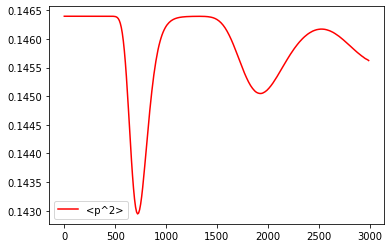

In [56]:
plt.plot(t, np.real(p2_of_t), 'red', label='<p^2>')
#plt.plot(t, np.real(p_of_t), 'blue', label='<p>')
#plt.plot(t, np.real(p_sig_of_t), 'green', label='sigma_p')
plt.legend()
plt.show()

# Reference Link
http://tiao.io/posts/notebooks/embedding-matplotlib-animations-in-jupyter-as-interactive-javascript-widgets/